# Fit, tune and evaluate a crop type classifier

## Background

We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) implemented in the [`scikit-learn`](https://scikit-learn.org/stable/) Python libary to map crop type. 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

A number of hyperparameters can be tuned for this classifier and we will use funtionalities provided by the [`scikit-learn`](https://scikit-learn.org/stable/) libary to tune and evaluate the model.

## Description

This notebook demonstrates how to fit, tune and evaluate the crop type classification model. We will use the subset of training features balanced and selected in the [feature selection notebook](3_Training_feature_selection.ipynb)



## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from odc.io.cgroups import get_cpu_quota
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    cross_validate,
)
from sklearn import model_selection
from sklearn.metrics import  accuracy_score,confusion_matrix,precision_score, recall_score

## Load training data and label dictionary

The input features have been class balanced and highly correlated features are removed.

In [2]:
model_basepath = "Results/Model"

# Training data file from previous step
data_path = os.path.join(model_basepath,"single_crops_merged_training_features_2022_selected.csv")

# Dictionary with class labels from previous step
labels_path = os.path.join(model_basepath,"class_labels.json")

In [3]:
# load the data
model_input_df = pd.read_csv(data_path)
label_col = model_input_df.columns[0]
feature_cols = model_input_df.columns[1:]

# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

In [4]:
labels_dict

{'Maize': 0, 'Others': 1, 'Sesame': 2, 'Soy': 3}

### Split the data into features and labels

In [5]:
# split into features and labels
X = model_input_df.drop(label_col, axis=1).values
y = model_input_df[[label_col]].values.ravel()

### Get number of cpus available

In [6]:
ncpus = round(get_cpu_quota())
print("ncpus = " + str(ncpus))

ncpus = 15


## Grid search for optimal hyperparameters

A number of hyperparameters can be tuned to optimize the performance of a random forest algorithm. These parameters specifiy how many decision trees are used, when and how data are split into nodes, how many samples and features are used when looking for the best split, and so on. A complete list of parameters and their explanations can be found in the [library documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In our example, we perform a grid search of the following four hyperparameters:

* `class_weight`: Weights associated with classes. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
* `max_features`: The number of features to consider when looking for the best split. If “sqrt”, then `max_features=sqrt(n_features)`. If “log2”, then `max_features=log2(n_features)`. If None, then `max_features=n_features`.
* `n_estimators`: The number of trees in the forest.
* `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see [Mathematical formulation](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).\

> Searching over a large grid takes time. For testing, the search can be applied on a subset of parameter options.

In [7]:
# full grid
rf_param_grid = {
    "class_weight": ["balanced", None],
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [200, 300, 400],
    "criterion": ["gini", "entropy"],
}

# small test grid
rf_param_grid = {
    "n_estimators": [200, 300],
    "criterion": ["gini", "entropy"],
}

### Grid search with cross validation

For the grid search, we use cross validation to evaluate the models. When performing cross validation, data is split into `n` folds. One fold is kept aside as test data, and the rest is used to train a model. This step is repeated until each fold has been used as a test set for a model trained on the other folds. Average performance over all folds are used to select the best model. This strategy helps to assess models' predictive ability on unseen data.

In [8]:
%%time

cv = model_selection.StratifiedShuffleSplit(
    n_splits=5, random_state=1)  # stratified shuffle K-fold splitting
rf = RandomForestClassifier()
print('Grid searching best hyper-parameters...')
grid_search = model_selection.GridSearchCV(
    estimator=rf, param_grid=rf_param_grid, cv=cv, n_jobs=ncpus, verbose=2)
grid_search.fit(X, y)
print('Optimal parameters: \n', grid_search.best_params_)

Grid searching best hyper-parameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimal parameters: 
 {'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 300}
CPU times: user 15.5 s, sys: 130 ms, total: 15.6 s
Wall time: 12min 14s


## Fit a classifier with selected hyperparameters

In [9]:
rf = RandomForestClassifier(
    **grid_search.best_params_, random_state=1, n_jobs=ncpus)

In [10]:
rf.fit(X,y)

RandomForestClassifier(criterion='entropy', n_estimators=300, n_jobs=15,
                       random_state=1)

### Examine feature importance

Feature importance shows which features have the largest effect on the model prediction. We will explore the top 10 most important features and visualize the importance of all features.

In [11]:
feature_names = model_input_df.drop(label_col, axis=1).columns

In [12]:
# most important features
feat_importance_indices=np.argsort(rf.feature_importances_)[::-1][:10]
print('most importance features: \n', feature_names[feat_importance_indices])

most importance features: 
 Index(['ndvi_mean_11', 'MNDWI_s2_semiannual_2021_07',
       'swir_1_s2_semiannual_2022_01', 'swir_1_s2_semiannual_2021_07',
       'ndvi_mean_10', 'npv_mean_Q4_2021', 'bs_mean_Q1_2022',
       'npv_mean_Q3_2022', 'ndvi_mean_7', 'emad_s2_semiannual_2021_07'],
      dtype='object')


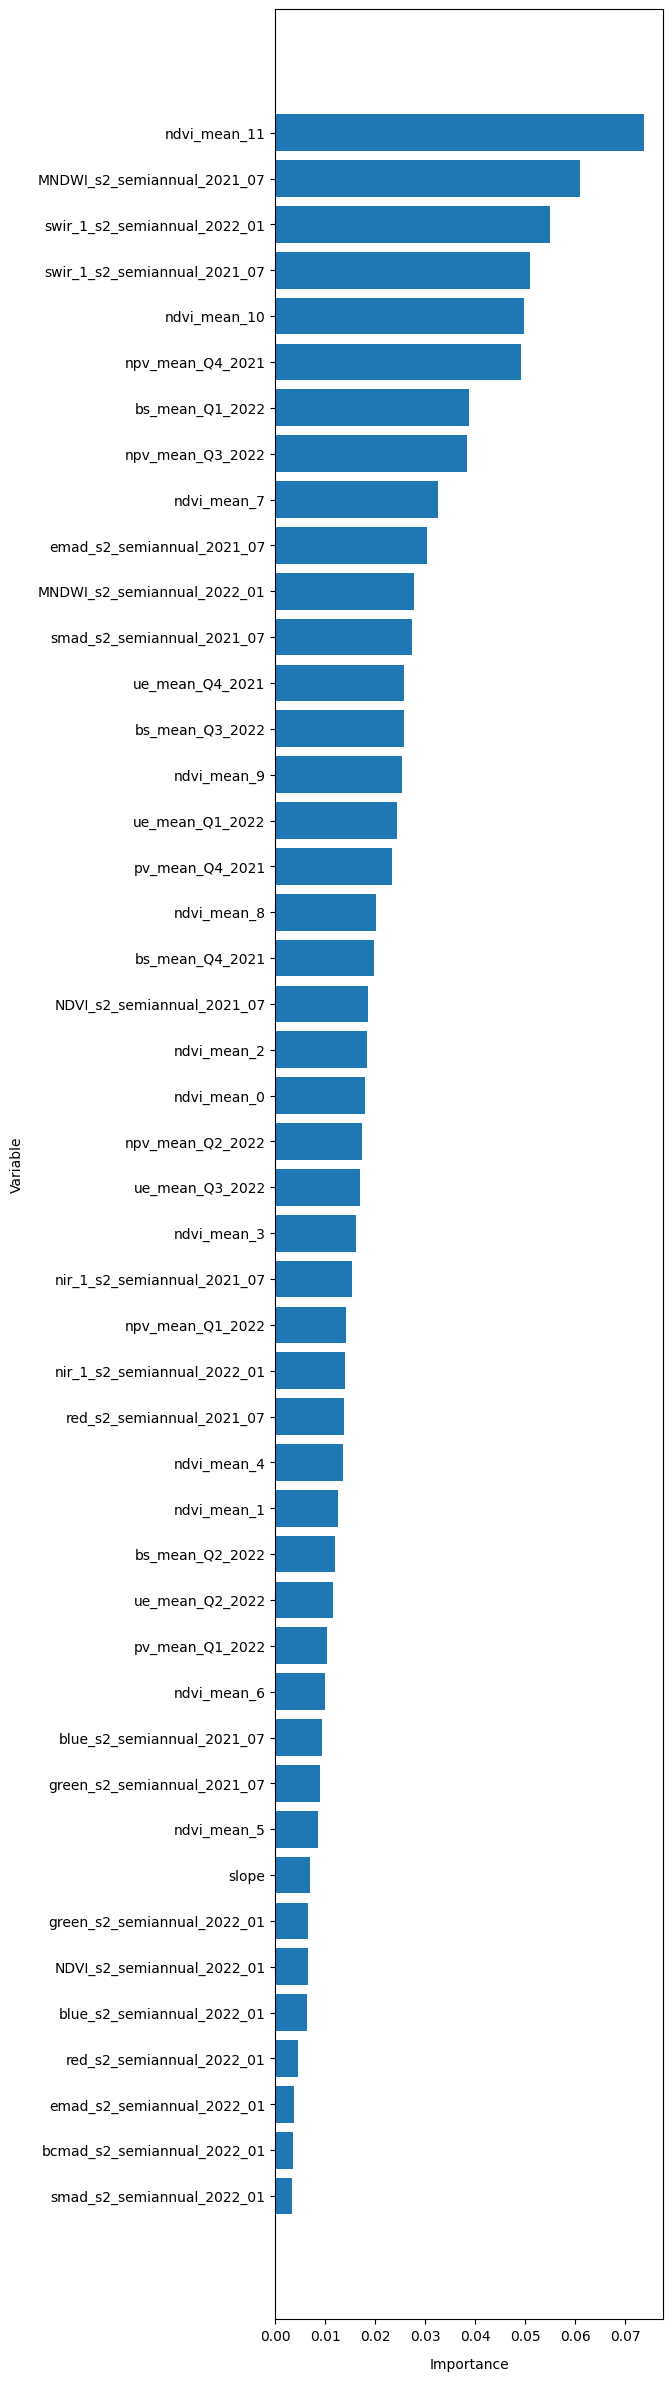

In [13]:
plt.figure(figsize=(5,30))
order=np.argsort(rf.feature_importances_)
plt.barh(y=np.array(feature_names[order]), width=rf.feature_importances_[order])
plt.gca().set_xlabel('Importance', labelpad=10);
plt.gca().set_ylabel('Variable', labelpad=10);

## Accuracy assessment

Finally we use a 5-fold cross validation to estimate the performance of the model. While the cross validation evaluates the predictive power of our model on unseen data, the result may not generalize for input data that have distinct spectral and temporal signatures to the training dataset. 

We will inspect four performance metrics:

* Overall accuracy
* Precision for each class - fraction of positive predictions that are correct. $precision = N_{True Positive}/(N_{True Positive} + N_{False Positive})$. The best value is 1 and the worst value is 0.
* Recall for each class - ability of the classifier to find all the positive samples. $recall = N_{True Positive}/(N_{True Positive} + N_{False Negative})$. The best value is 1 and the worst value is 0.
* F1 macro - averaged F1 scores for all classes. For each class, $F1 = 2*(precision*recall)/(precision+recall)$


In [14]:
skf = model_selection.StratifiedKFold(
    n_splits=5, shuffle=True, random_state=1)  # stratified K-fold splitting

overall_acc = model_selection.cross_val_score(
    rf, X, y, cv=skf, scoring='accuracy')
print('Overall accuracy from cv scores: ', np.mean(overall_acc))

Overall accuracy from cv scores:  0.9954566106315312


In [15]:
values = list(labels_dict.values())
predictions = model_selection.cross_val_predict(rf, X, y, cv=skf)
precision = precision_score(y, predictions, labels=values, average=None)
print('Precision for each class: \n', dict(
    zip([key for key in labels_dict.keys()], np.around(precision, 3))))

Precision for each class: 
 {'Maize': 0.997, 'Others': 0.998, 'Sesame': 0.991, 'Soy': 1.0}


In [16]:
recall = recall_score(y, predictions, labels=values, average=None)
print('Recall for each class: \n', dict(
    zip([key for key in labels_dict.keys()], np.around(recall, 3))))

Recall for each class: 
 {'Maize': 0.995, 'Others': 0.994, 'Sesame': 0.998, 'Soy': 0.989}


In [17]:
f1_macro = model_selection.cross_val_score(
    rf, X, y, cv=skf, scoring='f1_macro')
print('f1_macro from cv scores: ', np.mean(f1_macro))

f1_macro from cv scores:  0.9951980200659948


### Plot confusion matrix

The confusion matrix compares all predictions against the labels and allow us to see what types of prediction errors the model is making.  

Confusion matrix:



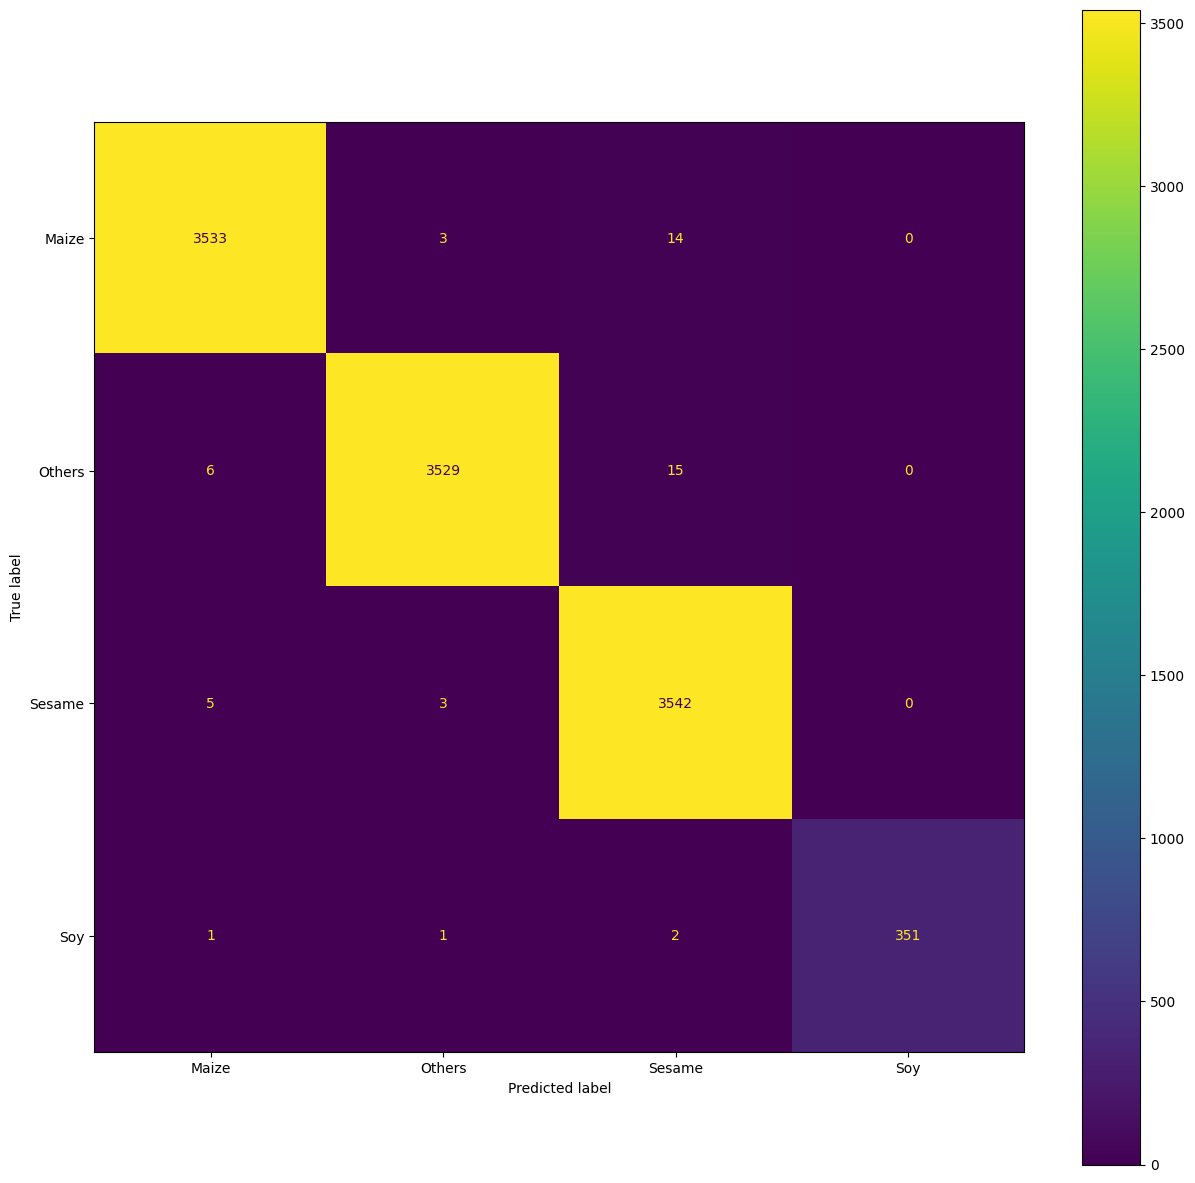

In [18]:
cm = confusion_matrix(y, predictions)
display_labels = [list(labels_dict.keys())[list(
    labels_dict.values()).index(i)] for i in rf.classes_]
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=display_labels)
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)

## Save the model

When we are satisfied with the model performance, we will save the model and features used to files with descriptive names.

In [19]:
# fit classifier using all samples and the optimised hyperparameters
dump(rf, os.path.join(model_basepath,"rf_removecorrfeaturesgt0p9_simplified_cv.joblib"))

# Export the columns to use in the final model
with open(os.path.join(model_basepath,"rf_removecorrfeaturesgt0p9_simplified_features.json"), "w", encoding="utf-8") as f:
    json.dump({"features": list(feature_names)}, f, ensure_ascii=False, indent=4)

[CV] END class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=200; total time=  10.8s
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=200; total time=   9.1s
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=400; total time=  18.1s
[CV] END class_weight=balanced, criterion=gini, max_features=None, n_estimators=400; total time= 2.9min
[CV] END class_weight=balanced, criterion=entropy, max_features=None, n_estimators=400; total time= 3.1min
[CV] END class_weight=None, criterion=gini, max_features=None, n_estimators=400; total time= 3.1min
[CV] END class_weight=None, criterion=entropy, max_features=None, n_estimators=400; total time= 2.3min
[CV] END class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=400; total time=  21.6s
[CV] END class_weight=balanced, criterion=gini, max_features=None, n_estimators=200; total time= 1.5min
[CV] END class_weight=balanced, criterion=entropy, max_features=sq